## Логика ноутбука: 

энкодим категориальные переменные, 

затем перебираем разные алгоритмы работы с несбалансированными данными, 

для каждого варианта реализуем MinMaxScaler и StandartScaler, 

выбираем лучший вариант по f1 на baseline CatBoostClassifier

In [11]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
%matplotlib inline
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from sklearn.preprocessing import OneHotEncoder
# !pip install category-encoders
from category_encoders.cat_boost import CatBoostEncoder

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from catboost import CatBoostClassifier


%matplotlib inline

In [6]:
df = pd.read_csv('df_train.csv')
df.head(8)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_cash_percent_cnt_2m,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,target
0,1f138e1545353a17e75025d76970bb94b73bb98886a914...,2021-07-31,1.0,RUS,378.666667,ACTIVE,0.0,Остатки на счетах,Корпоративный,MASS,...,0.104167,0.0,0.000000,0.095342,0.006045,0.000000,0.0,12.0,0.0,0.0
1,fa9a5e85e634829e7d5b0c6cedce9afb286073ef91f1cd...,2021-08-31,1.0,RUS,0.000000,SLEEP,0.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.0,0.0,0.0
2,7ff5fb356c7ce641de81b095990a1c5e17b5365ea6ea1e...,2022-04-30,1.0,RUS,3054.666667,ACTIVE,318.0,Пакет услуг,Премиум,AFFLUENT,...,0.000000,0.0,0.000000,0.000000,0.001069,0.000000,0.0,6.0,0.0,0.0
3,b7d3b6ec38e26f3976191a7490c426ea16deb2c7fdebbd...,2022-11-30,1.0,RUS,3947.500000,ACTIVE,0.0,Зарплата из кредитной анкеты,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,ab2036a31d5798d69bc1ef970cc98522b0c3ca8ce003f9...,2021-04-30,1.0,RUS,189.333333,ACTIVE,0.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.024797,0.000000,0.0,3.0,0.0,0.0
5,9f33adb0bcc6fdf026bc14f0dcf99c19969a0bffc93fbe...,2021-06-30,1.0,RUS,57.666667,ACTIVE,28.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.238945,0.057893,0.0,35.0,0.0,0.0
6,50d82481e54810811783b6a8e44cdaf655895b3d394bbe...,2022-07-31,1.0,RUS,4017.666667,ACTIVE,7451.0,Остатки на счетах,Технический,AFFLUENT,...,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
7,44aad3a1a9755cb0c249f3a348259bda6e336c39378d25...,2022-02-28,1.0,RUS,-515.666667,ACTIVE,791.0,Предиктивный доход,Технический,MAFFLUENT,...,0.050505,6.0,1.383657,0.000000,0.020024,0.074524,0.0,91.0,0.0,0.0


In [ ]:
#отбираем строковые переменные (КАТЕГОРИАЛЬНЫЕ)
data = df.copy()
xxx = data.select_dtypes(include = 'object')
xxx.head()

'''
смотрим: client_id - не признак
dt - дата
остальные: категориальные.
Правда, среди них могут быть и бинарные признаки. Выделим их:
'''
trash = ['client_id']
dates = ['dt']
xxx_categoricals = list(set(xxx.columns) - set(trash) - set(dates))

binaries = []
categoricals = []
for fea in xxx_categoricals:
    l = len(data[fea].value_counts())
    if l == 2:
        binaries.append(fea)
    elif l <= 1:
        trash.append(fea)
    else: #больше 2 уникальных значений за исключением nan
        categoricals.append(fea)
    
#отбираем числовые переменные
xxx = data.select_dtypes(include = 'number')
xxx.head()

'''
И как следовало ожидать, остальные 284 - числовые
target - исключаем из рассмотрения
'''
xxx.drop('target', axis = 1, inplace = True)
trash.append('target')

continuous = []
for fea in xxx.columns:
    l = len(data[fea].value_counts())
    if l == 2:
        binaries.append(fea)
    elif l <= 1:
        trash.append(fea)
    elif l>2 and l<=10: #больше 2 уникальных значений, но не более 10 за исключением nan
        categoricals.append(fea)
    else:
        continuous.append(fea)

categoricals.remove('hdb_bki_total_currency')
categoricals.remove('hdb_bki_active_oth_cnt')
continuous.append('hdb_bki_total_currency')
continuous.append('hdb_bki_active_oth_cnt')

del data

'''
НА ВЫХОДЕ:

binaries - бинарные признаки
categoricals - категориальные признаки
continuous - непрерывные признаки
dates - даты
trash - мусор
'''

In [30]:
categoricals

['srvpackage',
 'clientsegment',
 'country',
 'addrref',
 'clientoutflowstatus',
 'hdb_relend_client_credits_count_grade',
 'stratsegfactor']

In [7]:
df_test = pd.read_csv('df_test.csv')

In [8]:
df_test_orig=df_test.copy()
df_test.head(8)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_cash_percent_cnt_2m,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,target
0,97f3c73aa27980d8b66369474973b05ff1c93a8cbf5d07...,2022-04-30,0.0,RUS,0.000000,N2BANK_NEW,0.0,Инвестиционные продукты,Технический,MAFFLUENT,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,6846b905c6d77556ab93970fc1ffa651349bd344f9af84...,2021-12-31,0.0,RUS,0.000000,SLEEP,0.0,Зарплата из кредитной анкеты,длякредитовидепозитов,MASS,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,b31d16a6435112ab5b74005c8579f75743adfdd8a59382...,2022-03-31,1.0,RUS,8091.000000,SLEEP,0.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,faef7974c6c6b094578175f09522bf8257a28a167bb81e...,2021-05-31,0.0,RUS,1486.000000,SLEEP,0.0,Зарплата из кредитной анкеты,длякредитовидепозитов,MAFFLUENT,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,a545e9af11964956d85a5f24710978804e1289c008ec96...,2021-02-28,1.0,RUS,0.000000,POTENTIAL,0.0,NaN,Он-Лайф,MASS,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,91fd47d9175c37e829f4f5f3f4bbfffd723e4e38702e37...,2022-06-30,0.0,RUS,41.000000,ACTIVE,0.0,Инвестиционные продукты,Технический,MAFFLUENT,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,a4a8dfae50905b34ad394aed464b4cd2dbc9f255ee7f6f...,2022-07-31,1.0,RUS,3720.833333,ACTIVE,1394.0,Остатки на счетах,Технический,AFFLUENT,...,0.068182,0.0,0.0,0.0,0.001158,0.003177,0.000776,19.0,1.0,0.0
7,697e6ff7fee29aa98bfb4ef07b6bd788306b5950813cf8...,2022-04-30,0.0,RUS,-36.333333,ACTIVE,0.0,Остатки на счетах,Эконом,MASS,...,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


## Encoding

Кодируем фичи с большим числом значений с помощью CatBoostEncoder, остальные - OneHot Encoder

In [145]:
#X - образно, пока хз что за фичи брать
features = df.drop(['target', 'dt', 'client_id'], axis=1).columns
#значения, которые нужно закодировать по CBE
large_uniq = []
for i in list(set(categoricals)): #.intersection(set(features))
    if len(df[i].unique()) > 20:
        large_uniq.append(i)

other_cat_feature = set(categoricals).intersection(set(features)) - set(large_uniq)
other_cat_feature

{'clientoutflowstatus',
 'clientsegment',
 'hdb_relend_client_credits_count_grade',
 'stratsegfactor'}

In [148]:
other_cat_feature = set(other_cat_feature).union(set(['gender']))
other_cat_feature

{'clientoutflowstatus',
 'clientsegment',
 'gender',
 'hdb_relend_client_credits_count_grade',
 'stratsegfactor'}

In [150]:
large_uniq

['srvpackage', 'addrref', 'country']

In [151]:
categoricals

['srvpackage',
 'clientsegment',
 'country',
 'addrref',
 'clientoutflowstatus',
 'hdb_relend_client_credits_count_grade',
 'stratsegfactor']

In [426]:
for i in large_uniq:
        CBE_encoder = CatBoostEncoder(random_state=42)
        df[i] = CBE_encoder.fit_transform(df[i], df['target'] )
        df_t[i] = CBE_encoder.transform(df_t[i], df_t['target'])

In [153]:
class MultiColumnOneHotEncoder:
    def __init__(self):
        self.categories = {}
    
    def fit(self, data):
        for column in data.columns:
            unique_values = set(data[column])
            self.categories[column] = {}
            for index, value in enumerate(unique_values):
                self.categories[column][value] = index
            
    def transform(self, data):
        encoded_data = pd.DataFrame()
        for column in data.columns:
            for category, index in self.categories[column].items():
                encoded_data[f'{column}_{category}'] = (data[column] == category).astype(int)
        return encoded_data
  

In [427]:
encoder = MultiColumnOneHotEncoder()
encoder.fit(df[list(other_cat_feature)])
df_ohe = encoder.transform(df[list(other_cat_feature)])

In [155]:
df_ohe

,clientoutflowstatus_N2BANK_NEW,clientoutflowstatus_LOCAL_WB,clientoutflowstatus_OUTFLOW,clientoutflowstatus_ACTIVE,clientoutflowstatus_SLEEP,clientoutflowstatus_PREOUTFLOW,clientoutflowstatus_N2BANK_POTENTIAL,clientoutflowstatus_POTENTIAL,clientoutflowstatus_PREVYEARS_WB,hdb_relend_client_credits_count_grade_nan,...,clientsegment_MASS,stratsegfactor_Предиктивный доход,stratsegfactor_Реальная зарплата клиента,stratsegfactor_nan,stratsegfactor_Остатки на счетах,stratsegfactor_Зарплата из кредитной анкеты,stratsegfactor_Пакет услуг,stratsegfactor_Инвестиционные продукты,gender_Женский,gender_Мужской
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139229,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
139230,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
139231,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
139232,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [216]:
df_ohe=df_ohe.drop(['gender_Женский'],axis=1)

In [217]:
for i in df_ohe.columns:
    df[i]=df_ohe[i].values.copy()

In [218]:
df=df.drop(other_cat_feature, axis=1)

In [228]:
df

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,curbal_usd_amt_cm_avg,srvpackage,age,addrref,life_time_days,...,clientsegment_AFFLUENT,clientsegment_MASS,stratsegfactor_Предиктивный доход,stratsegfactor_Реальная зарплата клиента,stratsegfactor_nan,stratsegfactor_Остатки на счетах,stratsegfactor_Зарплата из кредитной анкеты,stratsegfactor_Пакет услуг,stratsegfactor_Инвестиционные продукты,gender_Мужской
0,1f138e1545353a17e75025d76970bb94b73bb98886a914...,2021-07-31,1.0,0.064675,378.666667,0.0,0.064675,43.0,0.064675,3240.0,...,0,1,0,0,0,1,0,0,0,0
1,fa9a5e85e634829e7d5b0c6cedce9afb286073ef91f1cd...,2021-08-31,1.0,0.064675,0.000000,0.0,0.064675,54.0,0.064675,5545.0,...,0,1,0,0,0,1,0,0,0,1
2,7ff5fb356c7ce641de81b095990a1c5e17b5365ea6ea1e...,2022-04-30,1.0,0.064675,3054.666667,318.0,0.064675,61.0,0.064675,4057.0,...,1,0,0,0,0,0,0,1,0,0
3,b7d3b6ec38e26f3976191a7490c426ea16deb2c7fdebbd...,2022-11-30,1.0,0.064675,3947.500000,0.0,0.064675,46.0,0.064675,933.0,...,0,1,0,0,0,0,1,0,0,1
4,ab2036a31d5798d69bc1ef970cc98522b0c3ca8ce003f9...,2021-04-30,1.0,0.064675,189.333333,0.0,0.064675,47.0,0.064675,4990.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139229,bc4eded4e47ca044c26766f709bc47442a1c0d4b3a42fe...,2021-06-30,1.0,0.064675,-67.333333,1.0,0.064675,64.0,0.064675,3169.0,...,0,1,0,0,0,1,0,0,0,0
139230,e6051ae5e50bfb4e063e660e002cfba95f11650fee77c5...,2022-12-31,1.0,0.064675,963.166667,1785.0,0.064675,30.0,0.064675,4406.0,...,1,0,0,0,0,0,0,1,0,1
139231,273546e99d4d56dcfb977e8aeb8838320ceda0d040434e...,2022-01-31,1.0,0.064675,189.666667,47.0,0.064675,71.0,0.064675,3946.0,...,0,1,0,0,0,1,0,0,0,1
139232,0997178bfe8eb49987dadf484435ed0d948de2c10fad79...,2022-09-30,1.0,0.064675,16115.500000,847.0,0.064675,37.0,0.064675,3847.0,...,0,1,0,0,0,1,0,0,0,0


In [219]:
features_new = list((set(features) - set(other_cat_feature)).union( set(df_ohe.columns)))

In [224]:
df_ohe_t = encoder.transform(df_t[list(other_cat_feature)])
df_ohe_t=df_ohe_t.drop(['gender_Женский'],axis=1)
df_ohe_t

,clientoutflowstatus_N2BANK_NEW,clientoutflowstatus_LOCAL_WB,clientoutflowstatus_OUTFLOW,clientoutflowstatus_ACTIVE,clientoutflowstatus_SLEEP,clientoutflowstatus_PREOUTFLOW,clientoutflowstatus_N2BANK_POTENTIAL,clientoutflowstatus_POTENTIAL,clientoutflowstatus_PREVYEARS_WB,hdb_relend_client_credits_count_grade_nan,...,clientsegment_AFFLUENT,clientsegment_MASS,stratsegfactor_Предиктивный доход,stratsegfactor_Реальная зарплата клиента,stratsegfactor_nan,stratsegfactor_Остатки на счетах,stratsegfactor_Зарплата из кредитной анкеты,stratsegfactor_Пакет услуг,stratsegfactor_Инвестиционные продукты,gender_Мужской
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46407,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
46408,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46409,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
46410,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [225]:
for i in df_ohe_t.columns:
    df_t[i]=df_ohe_t[i].values.copy()

In [226]:
df_t=df_t.drop(other_cat_feature, axis=1)

In [312]:
df_t['target']=df_test['target'].copy()
df_test_orig['target']=df_test['target'].copy()

In [229]:
df.to_csv('df.csv',index=False)
df_t.to_csv('df_t.csv',index=False)

# Upsampling

In [368]:
df['target'].value_counts()

0.0    130229
1.0      9005
Name: target, dtype: int64

<AxesSubplot: ylabel='Type'>

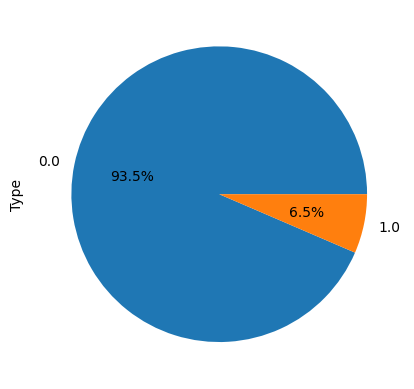

In [369]:
df.groupby('target').size().plot(kind='pie',
                                       y = "target",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [371]:
# отношение количества строк с target 0 к 1
rat = len(df.loc[df['target']==0])//len(df.loc[df['target']==1]) 
rat

14

0.0    130229
1.0    126070
Name: target, dtype: int64


<AxesSubplot: ylabel='Type'>

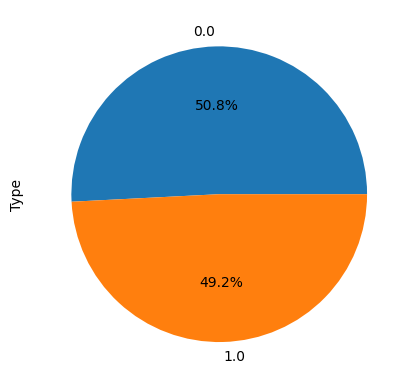

In [372]:
df_1 = df.loc[df['target']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
balance_up = pd.concat([df.loc[df['target']==0], df_1]).sample(frac=1)
print(balance_up['target'].value_counts())
balance_up.groupby('target').size().plot(kind='pie',
                                       y = "target",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [391]:
balance_up['target'].mean()

0.4918864295217695

In [392]:
balance_up.to_csv('df_train_UP.csv',index=False)

MinMaxScaler

In [393]:
df_train_UP=balance_up.copy()
df_t=df_test_orig.copy()

In [394]:
train=balance_up.copy()

In [395]:
for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [398]:
train.to_csv('df_train_UP_MinMax.csv',index=False)
df_t.to_csv('df_test_UP_MinMax.csv',index=False)

In [399]:
X = train.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110019
0:	learn: 0.6469061	total: 410ms	remaining: 6m 49s
100:	learn: 0.4125775	total: 9.9s	remaining: 1m 28s
200:	learn: 0.3752209	total: 19.2s	remaining: 1m 16s
300:	learn: 0.3448497	total: 28.6s	remaining: 1m 6s
400:	learn: 0.3196646	total: 37.9s	remaining: 56.6s
500:	learn: 0.2973386	total: 47.5s	remaining: 47.4s
600:	learn: 0.2778571	total: 57.2s	remaining: 38s
700:	learn: 0.2592855	total: 1m 6s	remaining: 28.3s
800:	learn: 0.2435189	total: 1m 15s	remaining: 18.9s
900:	learn: 0.2286515	total: 1m 25s	remaining: 9.43s
999:	learn: 0.2150618	total: 1m 35s	remaining: 0us
gini:  0.721
f1_score:  0.383
accuracy_score:  0.874
recall_score:  0.605
precision_score:  0.28


In [36]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.314


StandardScaler

In [400]:
train=df_train_UP.copy()
df_t=df_test_orig.copy()

In [401]:
for i in features_new:
    sc = StandardScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [403]:
train.to_csv('df_train_UP_StSc.csv',index=False)
df_t.to_csv('df_test_UP_StSc.csv',index=False)

In [404]:
X = train.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110019
0:	learn: 0.6469061	total: 121ms	remaining: 2m 1s
100:	learn: 0.4113891	total: 8.87s	remaining: 1m 18s
200:	learn: 0.3749044	total: 18.3s	remaining: 1m 12s
300:	learn: 0.3448054	total: 27.5s	remaining: 1m 3s
400:	learn: 0.3205074	total: 36.3s	remaining: 54.2s
500:	learn: 0.2977208	total: 45.9s	remaining: 45.7s
600:	learn: 0.2773941	total: 54.8s	remaining: 36.4s
700:	learn: 0.2593635	total: 1m 4s	remaining: 27.5s
800:	learn: 0.2430811	total: 1m 13s	remaining: 18.3s
900:	learn: 0.2284237	total: 1m 22s	remaining: 9.09s
999:	learn: 0.2149619	total: 1m 31s	remaining: 0us
gini:  0.722
f1_score:  0.39
accuracy_score:  0.876
recall_score:  0.611
precision_score:  0.286


In [35]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.32


In [ ]:
df_t=df_test_orig.copy()

# SMOTE 

In [425]:
df = pd.read_csv('df_train.csv')
df.head(8)

,client_id,dt,accountsalary_flag,country,profit_income_out_rur_amt_6m,clientoutflowstatus,curbal_usd_amt_cm_avg,stratsegfactor,srvpackage,clientsegment,...,transaction_category_cash_percent_cnt_2m,transaction_category_hotels_sum_cnt_m2,transaction_category_sporting_goods_inc_amt_2m,transaction_category_airplane_tickets_percent_amt_2m,transaction_category_transport_percent_amt_2m,transaction_category_restaurants_percent_amt_2m,transaction_category_auto_services_percent_amt_2m,transaction_category_supermarket_sum_cnt_m2,transaction_category_auto_services_sum_cnt_m2,target
0,1f138e1545353a17e75025d76970bb94b73bb98886a914...,2021-07-31,1.0,RUS,378.666667,ACTIVE,0.0,Остатки на счетах,Корпоративный,MASS,...,0.104167,0.0,0.000000,0.095342,0.006045,0.000000,0.0,12.0,0.0,0.0
1,fa9a5e85e634829e7d5b0c6cedce9afb286073ef91f1cd...,2021-08-31,1.0,RUS,0.000000,SLEEP,0.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.0,0.0,0.0
2,7ff5fb356c7ce641de81b095990a1c5e17b5365ea6ea1e...,2022-04-30,1.0,RUS,3054.666667,ACTIVE,318.0,Пакет услуг,Премиум,AFFLUENT,...,0.000000,0.0,0.000000,0.000000,0.001069,0.000000,0.0,6.0,0.0,0.0
3,b7d3b6ec38e26f3976191a7490c426ea16deb2c7fdebbd...,2022-11-30,1.0,RUS,3947.500000,ACTIVE,0.0,Зарплата из кредитной анкеты,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,ab2036a31d5798d69bc1ef970cc98522b0c3ca8ce003f9...,2021-04-30,1.0,RUS,189.333333,ACTIVE,0.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.024797,0.000000,0.0,3.0,0.0,0.0
5,9f33adb0bcc6fdf026bc14f0dcf99c19969a0bffc93fbe...,2021-06-30,1.0,RUS,57.666667,ACTIVE,28.0,Остатки на счетах,Технический,MASS,...,0.000000,0.0,0.000000,0.000000,0.238945,0.057893,0.0,35.0,0.0,0.0
6,50d82481e54810811783b6a8e44cdaf655895b3d394bbe...,2022-07-31,1.0,RUS,4017.666667,ACTIVE,7451.0,Остатки на счетах,Технический,AFFLUENT,...,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
7,44aad3a1a9755cb0c249f3a348259bda6e336c39378d25...,2022-02-28,1.0,RUS,-515.666667,ACTIVE,791.0,Предиктивный доход,Технический,MAFFLUENT,...,0.050505,6.0,1.383657,0.000000,0.020024,0.074524,0.0,91.0,0.0,0.0


In [301]:
X = df[features_new]
y = df.target
counter = Counter(y)
counter

Counter({0.0: 130229, 1.0: 9005})

In [9]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)

In [233]:
X

,hdb_bki_total_oth_cnt,stratsegfactor_Инвестиционные продукты,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__dom_kvartira,clientoutflowstatus_OUTFLOW,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kino,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kofejni,profit_income_out_rur_amt_12m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__meditsinskie_tsentry,stratsegfactor_Остатки на счетах,transaction_category_transport_percent_cnt_2m,...,hdb_bki_total_pil_max_limit,transaction_category_fastfood_sum_cnt_m2,transaction_category_sporting_goods_percent_cnt_2m,transaction_category_auto_services_percent_cnt_2m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__hobbi,hdb_relend_client_credits_count_grade_nan,hdb_bki_total_pil_last_days,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,depos_rur_amt_3m_avg,transaction_category_other_retail_purchase_inc_amt_2m
0,0.000000,0,0.000000,0,0.000000,299.000000,385.083333,0.000000,1,0.041667,...,1.310000e+05,1.000000,0.000000,0.000000,0.000000,0,2296.000000,71300.000000,0.0,1.972046
1,0.000000,0,0.000000,0,0.000000,0.000000,30.583333,0.000000,1,0.000000,...,3.600000e+04,0.000000,0.000000,0.000000,0.000000,0,5545.000000,0.000000,0.0,0.000000
2,0.000000,0,0.000000,0,0.000000,0.000000,2010.083333,0.000000,0,0.027027,...,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0,6729.000000,0.000000,1190630.0,0.846741
3,0.000000,0,0.000000,0,0.000000,0.000000,2429.416667,0.000000,0,0.000000,...,1.803430e+05,0.000000,0.000000,0.000000,0.000000,0,46.000000,0.000000,0.0,0.000000
4,0.000000,0,0.000000,0,0.000000,0.000000,378.083333,0.000000,1,0.125000,...,4.900000e+05,3.000000,0.000000,0.000000,0.000000,0,3236.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260453,0.000000,0,18184.175160,0,0.000000,0.000000,2698.879999,0.000000,0,0.000000,...,2.612308e+06,4.892167,0.000000,0.010752,464.755870,0,953.267940,172204.280348,0.0,1.373884
260454,0.000000,0,2204.714521,0,0.000000,0.000000,3597.716048,4668.336307,0,0.128051,...,1.385386e+05,21.270556,0.014509,0.000000,1609.794340,0,2477.789362,29972.146866,0.0,0.976614
260455,0.000000,0,4714.357873,0,617.764121,0.000000,-1920.427446,908.476649,0,0.035627,...,3.943489e+05,24.409091,0.004191,0.006287,4103.286196,0,5175.659679,320995.082530,0.0,0.663678
260456,0.000000,0,29942.838362,0,2513.232624,5300.919796,2137.697051,0.000000,0,0.161409,...,6.567345e+03,39.843417,0.000000,0.000198,0.000000,0,6218.635216,234004.613514,0.0,3.196566


In [ ]:
train = X.copy()
train['target'] = y.copy()
train.to_csv('df_train_SMOTE.csv',index=False)

In [237]:
train.to_csv('df_train_SMOTE.csv',index=False)

In [303]:
train = pd.read_csv('df_train_SMOTE.csv')

In [304]:
df_train_SMOTE=train.copy()
df_t=df_test_orig.copy()

MinMaxScaler

In [306]:
for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [313]:
train.to_csv('df_train_SMOTE_MinMax.csv',index=False)
df_t.to_csv('df_test_SMOTE_MinMax.csv',index=False)

In [14]:
train = pd.read_csv('df_train_SMOTE_MinMax.csv')
df_t = pd.read_csv('df_test_SMOTE_MinMax.csv')

X = train.drop([ 'target'],axis=1)
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.6000376	total: 229ms	remaining: 3m 49s
100:	learn: 0.1144772	total: 9.47s	remaining: 1m 24s
200:	learn: 0.1024179	total: 18.3s	remaining: 1m 12s
300:	learn: 0.0964256	total: 27.8s	remaining: 1m 4s
400:	learn: 0.0920006	total: 36.5s	remaining: 54.6s
500:	learn: 0.0881766	total: 45.4s	remaining: 45.2s
600:	learn: 0.0848086	total: 54.4s	remaining: 36.1s
700:	learn: 0.0818569	total: 1m 3s	remaining: 27.2s
800:	learn: 0.0791960	total: 1m 13s	remaining: 18.1s
900:	learn: 0.0760973	total: 1m 22s	remaining: 9.06s
999:	learn: 0.0737380	total: 1m 31s	remaining: 0us
gini:  0.728
f1_score:  0.311
accuracy_score:  0.939
recall_score:  0.212
precision_score:  0.586


In [34]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.243


StandardScaler

In [314]:
train =df_train_SMOTE.copy()
df_t=df_test_orig.copy()

In [315]:
for i in features_new:
    sc = StandardScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [318]:
train.to_csv('df_train_SMOTE_StSc.csv',index=False)
df_t.to_csv('df_test_SMOTE_StSc.csv',index=False)

In [15]:
train = pd.read_csv('df_train_SMOTE_StSc.csv')
df_t = pd.read_csv('df_test_SMOTE_StSc.csv')

X = train.drop([ 'target'],axis=1)
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.6000376	total: 121ms	remaining: 2m
100:	learn: 0.1161863	total: 10s	remaining: 1m 29s
200:	learn: 0.1042349	total: 19.5s	remaining: 1m 17s
300:	learn: 0.0974876	total: 28.5s	remaining: 1m 6s
400:	learn: 0.0921584	total: 37.7s	remaining: 56.4s
500:	learn: 0.0883316	total: 46.7s	remaining: 46.5s
600:	learn: 0.0849219	total: 55.9s	remaining: 37.1s
700:	learn: 0.0819942	total: 1m 4s	remaining: 27.6s
800:	learn: 0.0791208	total: 1m 14s	remaining: 18.4s
900:	learn: 0.0764635	total: 1m 23s	remaining: 9.17s
999:	learn: 0.0739892	total: 1m 32s	remaining: 0us
gini:  0.726
f1_score:  0.312
accuracy_score:  0.939
recall_score:  0.214
precision_score:  0.58


In [33]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.245


# SMOTE + UPSAMPLING

In [319]:
df_t=df_test_orig.copy()

In [320]:
X = df[features_new]
y = df.target
counter = Counter(y)
counter

Counter({0.0: 130229, 1.0: 9005})

In [321]:
rat1 = len(df.loc[df['target']==0])//len(df.loc[df['target']==1]) * 0.75
rat1 #во сколько раз умножаем

10.5

In [322]:
df_3 = df.loc[df['target']==1]
df_3 = df_3.loc[df_3.index.repeat(rat)]
balance_up2 = pd.concat([df.loc[df['target']==0], df_3]).sample(frac=1)
print(balance_up2['target'].value_counts())
features = features_new.copy()

0.0    130229
1.0     90050
Name: target, dtype: int64


In [323]:
df_model = balance_up2[features]
X = pd.get_dummies(df_model)
y = balance_up2.target
counter = Counter(y)
oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

In [324]:
counter = Counter(y_res)
counter

Counter({1.0: 130229, 0.0: 130229})

In [325]:
X_res

,hdb_bki_total_oth_cnt,stratsegfactor_Инвестиционные продукты,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__dom_kvartira,clientoutflowstatus_OUTFLOW,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kino,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kofejni,profit_income_out_rur_amt_12m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__meditsinskie_tsentry,stratsegfactor_Остатки на счетах,transaction_category_transport_percent_cnt_2m,...,hdb_bki_total_pil_max_limit,transaction_category_fastfood_sum_cnt_m2,transaction_category_sporting_goods_percent_cnt_2m,transaction_category_auto_services_percent_cnt_2m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__hobbi,hdb_relend_client_credits_count_grade_nan,hdb_bki_total_pil_last_days,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,depos_rur_amt_3m_avg,transaction_category_other_retail_purchase_inc_amt_2m
0,0.0,0,0.0,0,0.0,0.0,28.750000,0.0,1,0.000000,...,0.00,0.0,0.000000,0.000000,0.0000,0,6729.0,0.000000e+00,0.0,0.000000
1,0.0,0,1095.0,0,0.0,0.0,582.583333,0.0,0,0.167442,...,370000.00,1.0,0.000000,0.000000,1700.0000,0,952.0,8.160000e+04,0.0,1.382075
2,0.0,0,349.0,0,0.0,0.0,3568.083333,0.0,0,0.000000,...,53227.00,10.0,0.000000,0.000000,0.0000,0,566.0,5.191922e+05,0.0,0.321733
3,0.0,0,4861.0,0,0.0,0.0,1755.666667,0.0,0,0.084746,...,378000.00,28.0,0.000000,0.005650,0.0000,0,172.0,3.670000e+04,0.0,1.028723
4,0.0,1,0.0,0,0.0,0.0,0.000000,0.0,0,0.000000,...,0.00,0.0,0.000000,0.000000,0.0000,0,6729.0,0.000000e+00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260453,0.0,0,28049.0,0,800.0,0.0,37735.333333,0.0,0,0.026738,...,3485000.00,30.0,0.034759,0.002674,7176.0000,0,97.0,6.280000e+04,0.0,3.413474
260454,0.0,0,3550.0,0,24540.0,9914.0,17555.500000,16000.0,0,0.127226,...,98259.12,56.0,0.002545,0.017812,77323.0721,0,2535.0,9.067196e+06,0.0,0.537495
260455,0.0,0,0.0,0,0.0,0.0,7522.583333,0.0,0,0.052980,...,0.00,28.0,0.000000,0.019868,478.0000,0,6729.0,0.000000e+00,0.0,0.742860
260456,0.0,0,0.0,0,0.0,0.0,-12.285714,0.0,1,0.386667,...,241593.20,1.0,0.000000,0.000000,1300.0000,0,343.0,0.000000e+00,0.0,3.966667


In [326]:
len(y_res)

260458

In [327]:
train = X_res.copy()
train['target'] = y_res.copy()

In [328]:
train

,hdb_bki_total_oth_cnt,stratsegfactor_Инвестиционные продукты,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__dom_kvartira,clientoutflowstatus_OUTFLOW,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kino,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__kofejni,profit_income_out_rur_amt_12m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__meditsinskie_tsentry,stratsegfactor_Остатки на счетах,transaction_category_transport_percent_cnt_2m,...,transaction_category_fastfood_sum_cnt_m2,transaction_category_sporting_goods_percent_cnt_2m,transaction_category_auto_services_percent_cnt_2m,amount_by_category_30d__summarur_amt__SUM__cashflowcategory_name__hobbi,hdb_relend_client_credits_count_grade_nan,hdb_bki_total_pil_last_days,amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,depos_rur_amt_3m_avg,transaction_category_other_retail_purchase_inc_amt_2m,target
0,0.0,0,0.0,0,0.0,0.0,28.750000,0.0,1,0.000000,...,0.0,0.000000,0.000000,0.0000,0,6729.0,0.000000e+00,0.0,0.000000,1.0
1,0.0,0,1095.0,0,0.0,0.0,582.583333,0.0,0,0.167442,...,1.0,0.000000,0.000000,1700.0000,0,952.0,8.160000e+04,0.0,1.382075,0.0
2,0.0,0,349.0,0,0.0,0.0,3568.083333,0.0,0,0.000000,...,10.0,0.000000,0.000000,0.0000,0,566.0,5.191922e+05,0.0,0.321733,1.0
3,0.0,0,4861.0,0,0.0,0.0,1755.666667,0.0,0,0.084746,...,28.0,0.000000,0.005650,0.0000,0,172.0,3.670000e+04,0.0,1.028723,1.0
4,0.0,1,0.0,0,0.0,0.0,0.000000,0.0,0,0.000000,...,0.0,0.000000,0.000000,0.0000,0,6729.0,0.000000e+00,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260453,0.0,0,28049.0,0,800.0,0.0,37735.333333,0.0,0,0.026738,...,30.0,0.034759,0.002674,7176.0000,0,97.0,6.280000e+04,0.0,3.413474,1.0
260454,0.0,0,3550.0,0,24540.0,9914.0,17555.500000,16000.0,0,0.127226,...,56.0,0.002545,0.017812,77323.0721,0,2535.0,9.067196e+06,0.0,0.537495,1.0
260455,0.0,0,0.0,0,0.0,0.0,7522.583333,0.0,0,0.052980,...,28.0,0.000000,0.019868,478.0000,0,6729.0,0.000000e+00,0.0,0.742860,1.0
260456,0.0,0,0.0,0,0.0,0.0,-12.285714,0.0,1,0.386667,...,1.0,0.000000,0.000000,1300.0000,0,343.0,0.000000e+00,0.0,3.966667,1.0


In [261]:
train['target'].mean()

0.5

In [329]:
train.to_csv('df_train_SMOTE_UP.csv',index=False)

In [330]:
df_train_SMOTE_UP=train.copy()
df_test_orig=df_t.copy()

MinMaxScaler

In [331]:
for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [340]:
train.to_csv('df_train_SMOTE_UP_MinMax.csv',index=False)
df_t.to_csv('df_test_SMOTE_UP_MinMax.csv',index=False)

In [31]:
train = pd.read_csv('df_train_SMOTE_UP_MinMax.csv')
df_t = pd.read_csv('df_test_SMOTE_UP_MinMax.csv')

X = train.drop([ 'target'],axis=1)
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt','target'],axis=1)
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

gini:  0.718
f1_score:  0.383
accuracy_score:  0.874
recall_score:  0.605
precision_score:  0.28


In [32]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.314


StandardScaler

In [342]:
train=df_train_SMOTE_UP.copy()
df_t=df_test_orig.copy()

In [343]:
for i in features_new:
    sc = StandardScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [345]:
train.to_csv('df_train_SMOTE_UP_StSc.csv',index=False)
df_t.to_csv('df_test_SMOTE_UP_StSc.csv',index=False)

In [20]:
train = pd.read_csv('df_train_SMOTE_UP_StSc.csv')
df_t = pd.read_csv('df_test_SMOTE_UP_StSc.csv')

X = train.drop([ 'target'],axis=1)
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt','target'],axis=1)
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

gini:  0.718
f1_score:  0.378
accuracy_score:  0.873
recall_score:  0.597
precision_score:  0.277


In [29]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.31


In [351]:
df_t=df_test_orig.copy()

# ADASYN + UPSAMPLING

In [353]:
rat1 = len(df.loc[df['target']==0])//len(df.loc[df['target']==1]) * 0.75
rat1 #во сколько раз умножаем
df_3 = df.loc[df['target']==1]
df_3 = df_3.loc[df_3.index.repeat(rat)]
balance_up2 = pd.concat([df.loc[df['target']==0], df_3]).sample(frac=1)
print(balance_up2['target'].value_counts())
features = features_new.copy()

0.0    130229
1.0     90050
Name: target, dtype: int64


In [ ]:
ada = ADASYN()
df_model = balance_up2[features]
X = pd.get_dummies(df_model)
y = balance_up2.target
X_resampled, y_resampled = ada.fit_resample(X, y)
counter = Counter(y_resampled)

In [ ]:
train = X_resampled.copy()
train['target'] = y_resampled.copy()

In [293]:
train.to_csv('df_train_ADASYN_UP.csv',index=False)

MinMaxScaler

In [357]:
df_train_ADASYN_UP=train.copy()
df_t=df_test_orig.copy()

In [358]:
for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [360]:
train.to_csv('df_train_ADASYN_UP_MinMax.csv',index=False)
df_t.to_csv('df_test_ADASYN_UP_MinMax.csv',index=False)

In [410]:
train = pd.read_csv('df_train_ADASYN_UP_MinMax.csv')
df_t = pd.read_csv('df_test_ADASYN_UP_MinMax.csv')

X = train.drop(['target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.5979975	total: 103ms	remaining: 1m 42s
100:	learn: 0.3455819	total: 9.83s	remaining: 1m 27s
200:	learn: 0.3164117	total: 19.4s	remaining: 1m 17s
300:	learn: 0.2924922	total: 28.7s	remaining: 1m 6s
400:	learn: 0.2725015	total: 37.9s	remaining: 56.7s
500:	learn: 0.2547073	total: 47.1s	remaining: 46.9s
600:	learn: 0.2381708	total: 56.3s	remaining: 37.4s
700:	learn: 0.2235225	total: 1m 5s	remaining: 28.1s
800:	learn: 0.2096414	total: 1m 15s	remaining: 18.6s
900:	learn: 0.1972570	total: 1m 24s	remaining: 9.27s
999:	learn: 0.1856297	total: 1m 33s	remaining: 0us
gini:  0.726
f1_score:  0.402
accuracy_score:  0.894
recall_score:  0.551
precision_score:  0.316


In [28]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.348


StandardScaler

In [363]:
train=df_train_ADASYN_UP.copy()
df_t=df_test_orig.copy()

In [364]:
for i in features_new:
    sc = StandardScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [367]:
train.to_csv('df_train_ADASYN_UP_StSc.csv',index=False)
df_t.to_csv('df_test_ADASYN_UP_StSc.csv',index=False)

In [408]:
train = pd.read_csv('df_train_ADASYN_UP_StSc.csv')
df_t = pd.read_csv('df_test_ADASYN_UP_StSc.csv')

X = train.drop(['target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.5979975	total: 72ms	remaining: 1m 11s
100:	learn: 0.3456345	total: 9.13s	remaining: 1m 21s
200:	learn: 0.3154496	total: 18.4s	remaining: 1m 13s
300:	learn: 0.2911617	total: 28.1s	remaining: 1m 5s
400:	learn: 0.2713080	total: 37.4s	remaining: 55.9s
500:	learn: 0.2532487	total: 46.8s	remaining: 46.6s
600:	learn: 0.2368780	total: 56.7s	remaining: 37.6s
700:	learn: 0.2216695	total: 1m 6s	remaining: 28.3s
800:	learn: 0.2083501	total: 1m 15s	remaining: 18.8s
900:	learn: 0.1964769	total: 1m 24s	remaining: 9.29s
999:	learn: 0.1849643	total: 1m 33s	remaining: 0us
gini:  0.725
f1_score:  0.402
accuracy_score:  0.895
recall_score:  0.547
precision_score:  0.318


In [25]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.347


# ADASYN

In [414]:
X = df[features_new]
y = df.target
counter = Counter(y)

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, y)
counter = Counter(y_resampled)
counter

Counter({0.0: 130229, 1.0: 128219})

In [415]:
train = X_resampled.copy()
train['target'] = y_resampled.copy()

In [416]:
train.to_csv('df_train_ADASYN.csv',index=False)

MinMaxScaler

In [417]:
df_train_ADASYN=train.copy()
df_t=df_test_orig.copy()

In [418]:
for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [419]:
train.to_csv('df_train_ADASYN_MinMax.csv',index=False)
df_t.to_csv('df_test_ADASYN_MinMax.csv',index=False)

In [420]:
train = pd.read_csv('df_train_ADASYN_MinMax.csv')
df_t = pd.read_csv('df_test_ADASYN_MinMax.csv')


X = train.drop(['target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110412
0:	learn: 0.6114435	total: 107ms	remaining: 1m 46s
100:	learn: 0.1157120	total: 9.9s	remaining: 1m 28s
200:	learn: 0.1033735	total: 19.5s	remaining: 1m 17s
300:	learn: 0.0972046	total: 28.8s	remaining: 1m 6s
400:	learn: 0.0924402	total: 37.9s	remaining: 56.7s
500:	learn: 0.0882736	total: 47.1s	remaining: 46.9s
600:	learn: 0.0847268	total: 55.7s	remaining: 37s
700:	learn: 0.0813224	total: 1m 4s	remaining: 27.7s
800:	learn: 0.0782546	total: 1m 14s	remaining: 18.6s
900:	learn: 0.0757918	total: 1m 23s	remaining: 9.23s
999:	learn: 0.0732266	total: 1m 33s	remaining: 0us
gini:  0.728
f1_score:  0.314
accuracy_score:  0.94
recall_score:  0.213
precision_score:  0.6


In [24]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.245


StandardScaler

In [421]:
train=df_train_ADASYN.copy()
df_t=df_test_orig.copy()

In [422]:
for i in features_new:
    sc = StandardScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))

In [423]:
train.to_csv('df_train_ADASYN_StSc.csv',index=False)
df_t.to_csv('df_test_ADASYN_StSc.csv',index=False)

In [424]:
train = pd.read_csv('df_train_ADASYN_StSc.csv')
df_t = pd.read_csv('df_test_ADASYN_StSc.csv')

X = train.drop(['target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110412
0:	learn: 0.6114560	total: 105ms	remaining: 1m 44s
100:	learn: 0.1179872	total: 9.88s	remaining: 1m 27s
200:	learn: 0.1038457	total: 19.5s	remaining: 1m 17s
300:	learn: 0.0972671	total: 28.5s	remaining: 1m 6s
400:	learn: 0.0925724	total: 37.9s	remaining: 56.6s
500:	learn: 0.0880208	total: 46.9s	remaining: 46.7s
600:	learn: 0.0845368	total: 56.2s	remaining: 37.3s
700:	learn: 0.0814625	total: 1m 5s	remaining: 27.9s
800:	learn: 0.0783753	total: 1m 14s	remaining: 18.5s
900:	learn: 0.0756957	total: 1m 24s	remaining: 9.23s
999:	learn: 0.0734647	total: 1m 33s	remaining: 0us
gini:  0.729
f1_score:  0.314
accuracy_score:  0.94
recall_score:  0.213
precision_score:  0.599


In [23]:
print('f2_score: ', round(fbeta_score(y_t, pred,beta=2),3))

f2_score:  0.245


# Наилучший результат показало сочетание ADASYN + UPSAMPLING и MinMaxScaler

MinMaxScaler для датасета с дисбалансом

In [22]:
train = df.copy()
df_t=df_test_orig.copy()

for i in features_new:
    sc = MinMaxScaler()
    train[i] = sc.fit_transform(np.expand_dims(train[i].to_numpy(), axis=1))
    df_t[i] = sc.transform(np.expand_dims(df_t[i].to_numpy(), axis=1))
    
train.to_csv('df_train_MinMax.csv',index=False)
df_t.to_csv('df_test_MinMax.csv',index=False)